## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from copy import deepcopy
from pymongo import MongoClient
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from gensim import models, matutils

#import custom functions created for this project
from fletcher_functions import check_for_cat, filter_yelplist, Bar, LemmaTokenizer

## MongoDB

All the data that I received from the yelp challenge data set was stored on a mongodb server as the data itself was provided in JSON format

In [4]:
client = MongoClient()
db = client.yelp
db.list_collection_names()

['reviews', 'bars', 'business', 'users', 'bar_reviews']

Series of mongodB commands to segregate the data so that only reviews from relevant bars were utilized

In [3]:
# Create subset of business that contain bars in question
# db.business.aggregate([
#     {"$match": {'categories': {'$regex': 'Bars'}}},
#     {"$match": {"review_count": {"$gte": 50}}},
#     {"$out": "bars"}]);

# Create subset of reviews to only find reviews that contain the bar ids
locations = list(db.bars.find({}, {'_id': 0, 'business_id': 1, 'categories': 1}))
filtered_bars = filter_yelplist(locations, 'bars')
allbar_ids = [i['business_id'] for i in filtered_bars]

# db.reviews.aggregate([
#     {'$match': {'business_id': {'$in': allbar_ids}}},
#     {"$out": "bar_reviews"}]);

Utilized the Bar class object that I created to store the necessary information about each bar, the list of bars was then pickled as the process of generating each of the bar objects took about 50 minutes.

In [66]:
%%time 
# create bar objects for all items in bars, then pickle the list of objects

bars = []
query = list(db.bars.find({'business_id': {'$in': allbar_ids}}))
for i, ibar in enumerate(query):
    bar_object = Bar(ibar, i)
    bar_object.get_review_text(db.bar_reviews);
    bars.append(bar_object)
    
with open('bar_objects.pkl', 'wb') as filename:
    pickle.dump(bars, filename)
    filename.close()

# all_text = [ibar.reviewtext_ for ibar in bars]
# with open('bar_review_text.pkl', 'wb') as filename:
#     pickle.dump(all_text, filename)
#     filename.close()


CPU times: user 9min 43s, sys: 16 s, total: 9min 59s
Wall time: 47min 19s


## Pickling and Constants

In [2]:
# open bar objects from the pkl file
with open('bar_objects.pkl', 'rb') as filename:
    bars = pickle.load(filename)
    filename.close()

# access the state label for each bar, was used as coloration on tsne plots later on
state_labels = [ibar.json_item['state'] for ibar in bars]

Additional creation of categorical variables that would be used to create the feature space along with the topics generated by LDA

In [3]:
# alcohol categories and title
alcohol_categories = ['whiskey', 'vodka', 'beer', 'wine',
                      'tequila', 'rum', 'shot', 'gin',
                      'brandy', 'soju', 'cider', 'sake']
category_names = ['price'] + [f'{cat} presence' for cat in alcohol_categories]
category_array = []

# grabbed the assigned price range for each bar from the yelp dataset
price_range = []
for ibar in bars:
    bar_attributes = ibar.json_item['attributes']
    if bar_attributes is not None:
        price_range.append(int(bar_attributes.get('RestaurantsPriceRange2', 0))/4)
    else:
        price_range.append(0)
        
price_range = np.array(price_range).reshape(-1,1)

# appended the counts of each keyword that I identifed (dividing by the total number of reviews)
# to act as a "presence" indicator of each category
for i, ibar in enumerate(bars):
    reviewcount = ibar.reviewcount_
    category_numbers = np.array([ibar.collector[word] / reviewcount for word in alcohol_categories])
    if i == 0:
        alcohol_array = category_numbers
    else:
        alcohol_array = np.vstack((alcohol_array, category_numbers))

# category array that would be appended to the array generated by LDA        
category_array = np.hstack((price_range, alcohol_array))

In [4]:
LT = LemmaTokenizer()
ssX = StandardScaler()

# Stop words associated with location, wanted recommender to be location agnostic
additional_stopwords = ['restaurant', 'vegas', 'waitress', 'dinner',
                        'wa', 'waiter', 'scottsdale', 'toronto',
                       'pittsburgh', 'madison', 'fremont', 'manager',
                       'husband', 'phoenix', 'dakota', 'caesar', 
                       'bellagio', 'canal', 'venetian', 'mandalay',
                       'lotus', 'siam', 'buca','beppo',
                       'di', 'buca', 'ohio', 'tretmont',
                       'bathroom', 'montreal', 'italy', 'et', 'est',
                       'que', 'il', 'en', 'la', 'une', 'pa', 'hostess']

# food related stopwords that I needed to remove as this was a bar recommender not a restaurant recommender
food_stopwords = ['chicken', 'curry', 'steak', 'egg', 'pork', 'meat',
                 'sandwich', 'cheese', 'pasta', 'salad', 'taco', 'salsa',
                 'guacamole', 'bruschetta', 'fish', 'dessert', 'onion',
                 'bun', 'sushi', 'sashimi', 'shrimp', 'crab', 'seafood',
                 'lobster', 'meatball', 'potato', 'entree', 'burrito',
                 'tortilla', 'food', 'olive', 'ramen', 'rib', 'brisket',
                 'bbq', 'bean', 'chip', 'mac', 'rice', 'beef', 'avocado', 
                 'pizza', 'garlic', 'crust', 'burger', 'bacon', 'meal',
                 'toast', 'bread', 'lunch', 'breakfast', 'appetizer',
                 'filet', 'cake', 'sauce', 'dish', 'dining', 'pie',
                 'nacho', 'enchilada', 'wing', 'roll', 'salmon', 'oyster',
                 'soup', 'sausage', 'truffle', 'noodle', 'ravioli', 'lasagna',
                 'veal', 'buffet', 'tiramisu', 'eggplant', 'chocolate', 'scallop',
                 'chef', 'duck', 'butter', 'steakhouse', 'kobe', 'caviar',
                 'stroganoff', 'corn', 'mushroom', 'thai', 'prawn', 'coconut',
                 'pretzel', 'pho', 'tuna', 'donut', 'chili', 'panini', 'fig',
                 'holstein', 'calamari', 'pancake', 'fruit', 'pierogi', 'pierogis',
                 'pierogies', 'mignon', 'rare', 'medium', 'lamb', 'milkshake',
                 'ribeye', 'mashed', 'bone', 'bass', 'sea', 'guac', 'queso',
                 'fajitas', 'carne', 'pasty', 'asada', 'mozzarella', 'marsala',
                 'spaghetti', 'gnocchi', 'parm', 'alfredo', 'linguine', 'buffalo',
                 'falafel', 'hummus', 'pita', 'scrambled', 'risotto', 'fat',
                 'strip', 'roast', 'miso', 'tempura', 'udon', 'edamame',
                 'cucumber', 'dipping', 'yellowtail', 'waffle', 'quesadilla', 'dog',
                 'primanti', 'tot', 'tater', 'phyllo', 'pomegranate', 'cinnamon',
                 'shepherd', 'banger', 'corned', 'foie', 'gras', 'latte', 'banana',
                 'poutine', 'seabass', 'du', 'je', 'au', 'mais', 'très', 'asparagus',
                 'slider', 'tikka', 'naan', 'popcorn', 'masala', 'bonefish', 'lime']

# Lemmatized each of the tokens to deal with plurals
additional_tokens = [LT(word)[0] for word in additional_stopwords + food_stopwords]

# Countvectorizer ended up being more descriptive than tfidf
cv = CountVectorizer(stop_words =
                     ENGLISH_STOP_WORDS.union(additional_tokens),
                     ngram_range = (1,2), max_df = 0.7, min_df = 30,
                      tokenizer = LemmaTokenizer())

## Topic Modeling

In [5]:
# open the list of all the of the bar review text for each bar, each entry is all the of reviews for each
# bar joined together, this forms the corpus of my recommender
with open('bar_review_text.pkl', 'rb') as filename:
    cv_data = cv.fit_transform(pickle.load(filename))
    filename.close()
    
corpus = matutils.Sparse2Corpus(cv_data.transpose())

In [ ]:
id2word = {identifier: word for word, identifier in cv.vocabulary_.items()}
lda = models.LdaModel(corpus=corpus, num_topics=9, minimum_probability=0.03, id2word=id2word, passes=10)
# pickled lda model as this took time to generate each time
with open('topic_model.pkl', 'wb') as filename:
    pickle.dump(lda, filename)
    filename.close()

In [6]:
# The 9 topics that I ended up with from LDA
with open('topic_model.pkl', 'rb') as filename:
    lda = pickle.load(filename)
    filename.close()
lda.print_topics()

[(0,
  '0.013*"fix" + 0.004*"reservation" + 0.004*"casino" + 0.003*"adult" + 0.002*"martini" + 0.001*"trendy" + 0.001*"hotel" + 0.001*"perfection" + 0.001*"lounge" + 0.001*"floor"'),
 (1,
  '0.002*"patio" + 0.001*"margarita" + 0.001*"mexican" + 0.001*"pub" + 0.001*"sport" + 0.001*"beer selection" + 0.001*"downtown" + 0.001*"dip" + 0.001*"bowl" + 0.001*"outdoor"'),
 (2,
  '0.011*"italian" + 0.004*"view" + 0.003*"upstairs" + 0.003*"overlooking" + 0.003*"reservation" + 0.003*"grand" + 0.002*"romantic" + 0.002*"coffee" + 0.002*"floor" + 0.002*"hotel"'),
 (3,
  '0.019*"band" + 0.015*"brunch" + 0.010*"bluegrass" + 0.009*"club" + 0.007*"dance" + 0.006*"dancing" + 0.006*"tavern" + 0.005*"cover" + 0.005*"country" + 0.005*"live music"'),
 (4,
  '0.063*"hookah" + 0.045*"karaoke" + 0.034*"song" + 0.029*"piano" + 0.022*"lounge" + 0.016*"sing" + 0.013*"singing" + 0.011*"samba" + 0.011*"entertainment" + 0.009*"singer"'),
 (5,
  '0.005*"reservation" + 0.004*"view" + 0.003*"coffee" + 0.003*"brunch" + 0

In [7]:
# Labels for each of the 9 topics
topic_labels = ['trendy hotel', 'outdoors', 'upscale',
                'live entertainment & dancing', 'hookah & karoke',
               'brunch place', 'cigar lounge',
                'russian', 'arcade & video games']
feature_columns = topic_labels + category_names

In [8]:
# pass text from corpus to my LDA model
lda_corpus = lda[corpus]
# changed type of corpus to csc
csc2_corpus = matutils.corpus2csc(lda_corpus).toarray().transpose()
# appended values from categorical features to my csc corpus
modified_csc2corpus = np.hstack((csc2_corpus, category_array))
# standard scaled the entire array due to the presence of the categorical features
scaled_corpus = ssX.fit_transform(modified_csc2corpus)

In [9]:
# bar_df contained the value of each bar for each of the features in my dimensionally reduced space
bardf_data = {label: values for label, values in zip(feature_columns, scaled_corpus.T)}
bar_df = pd.DataFrame(bardf_data)
bar_df.head()

,trendy hotel,outdoors,upscale,live entertainment & dancing,hookah & karoke,brunch place,cigar lounge,russian,arcade & video games,price,...,beer presence,wine presence,tequila presence,rum presence,shot presence,gin presence,brandy presence,soju presence,cider presence,sake presence
0,-0.127317,0.974770,-0.203853,-0.287768,-0.112019,-0.733777,-0.103905,-0.136819,-0.204775,-2.049496,...,-0.351976,-0.364262,-0.171960,-0.11984,-0.187613,-0.181265,-0.177736,-0.053938,-0.108141,-0.173881
1,-0.127317,0.890256,-0.203853,-0.287768,-0.112019,-0.733777,-0.103905,-0.136819,-0.204775,-2.049496,...,-0.270534,-0.390078,-0.171960,-0.11984,0.148061,-0.181265,-0.177736,-0.053938,-0.108141,-0.173881
2,-0.127317,-1.057564,-0.203853,-0.287768,-0.112019,1.261414,-0.103905,-0.136819,-0.204775,-0.033714,...,-0.632451,-0.249862,-0.171960,-0.11984,-0.511383,-0.181265,-0.177736,-0.053938,-0.108141,-0.173881
3,-0.127317,-2.265210,-0.203853,-0.287768,-0.112019,2.336987,-0.103905,-0.136819,-0.204775,1.982068,...,-0.659672,0.878153,0.335435,-0.11984,-0.128117,-0.181265,-0.177736,-0.053938,-0.108141,0.013049
4,-0.127317,0.836614,-0.203853,-0.287768,-0.112019,-0.733777,-0.103905,-0.136819,-0.204775,-0.033714,...,-0.292122,-0.358714,0.244638,-0.11984,-0.118031,-0.181265,-0.177736,-0.053938,-0.108141,-0.173881


## TSNE

TSNE was used to visual the clustering of the points after LDA and feature generation, was also useful to map the affect of each topic/feature on individual points in TSNE space.

In [20]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300, random_state = 2)
lda_Xtrain = tsne.fit_transform(scaled_corpus)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4006 samples in 0.035s...
[t-SNE] Computed neighbors for 4006 samples in 1.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4006
[t-SNE] Computed conditional probabilities for sample 2000 / 4006
[t-SNE] Computed conditional probabilities for sample 3000 / 4006
[t-SNE] Computed conditional probabilities for sample 4000 / 4006
[t-SNE] Computed conditional probabilities for sample 4006 / 4006
[t-SNE] Mean sigma: 0.352783
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.293243
[t-SNE] Error after 300 iterations: 1.307242


TSNE plot that shows that there is no clustering of states locations together

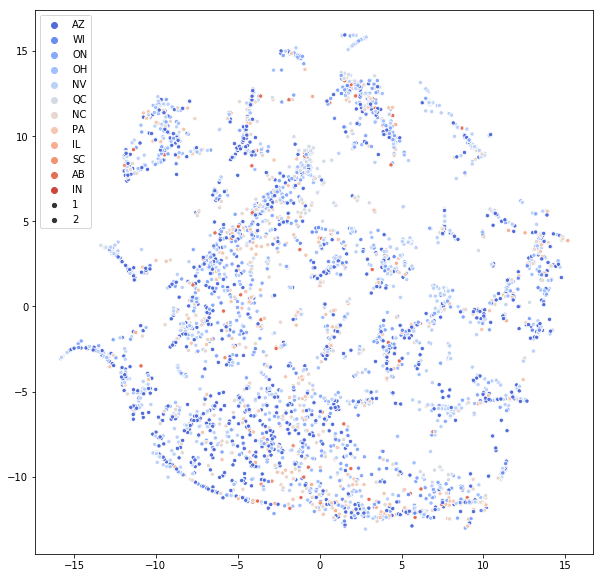

In [21]:
plt.rcParams.update({'figure.figsize': (10, 10)})
sns.scatterplot(lda_Xtrain[:, 0], lda_Xtrain[:, 1], state_labels,
                size = 2, palette = 'coolwarm', alpha = 'auto', 
               markers = '.')

TSNE plots of each of the features as their values are being mapped

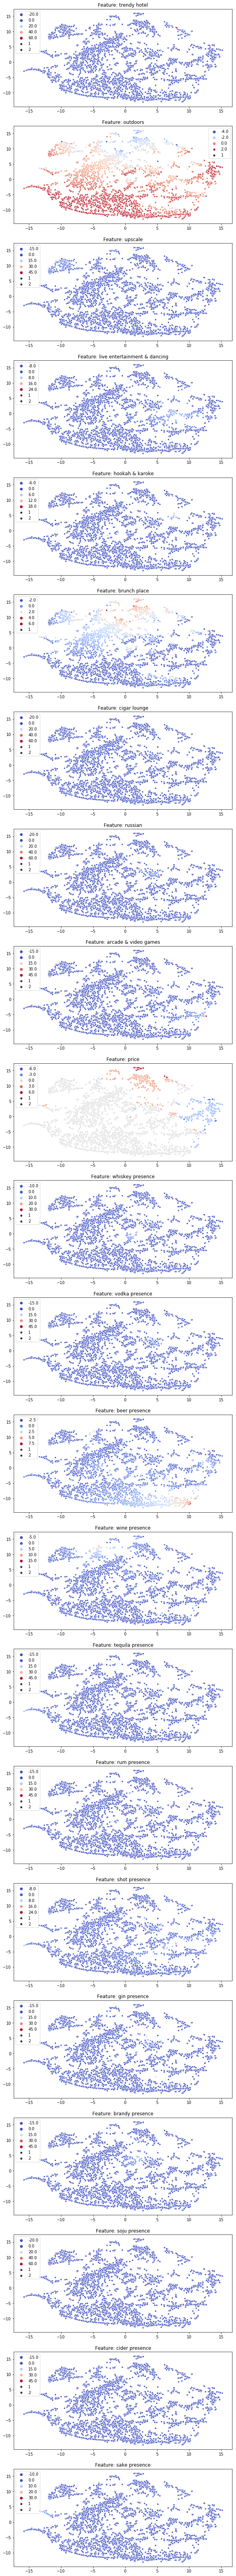

In [22]:
plt.rcParams.update({'figure.figsize': (10, 120)})
for i in range(len(feature_columns)):
    plt.subplot(len(feature_columns), 1, i+1)
    sns.scatterplot(lda_Xtrain[:, 0], lda_Xtrain[:, 1], scaled_corpus[:, i],
                size = 2, palette = 'coolwarm', alpha = 'auto', 
               markers = '.')
    plt.title(f'Feature: {feature_columns[i]}');

## Exporting csv files for Flask

Bar_df with names and tsne values exported so that they can be utilized in the Flask app

In [23]:
exported_data = deepcopy(bardf_data)

descriptive_features = [(ibar.name_, ibar.longitude_, ibar.latitude_,
                         ibar.json_item['state'], ibar.json_item['city'] )
                        for ibar in bars]

exported_data['name'] = [feat[0] for feat in descriptive_features]
exported_data['longitude'] = [feat[1] for feat in descriptive_features]
exported_data['latitude'] = [feat[2] for feat in descriptive_features]
exported_data['state'] = [feat[3] for feat in descriptive_features]
exported_data['city'] = [feat[4] for feat in descriptive_features]
exported_data['tsne_X'] = lda_Xtrain[:, 0]
exported_data['tsne_Y'] = lda_Xtrain[:, 1]

reordered_featurecols = ['name', 'longitude', 'latitude', 'state', 'city', 'tsne_X', 'tsne_Y'] + feature_columns

exported_bardf = pd.DataFrame(exported_data, columns = reordered_featurecols)

exported_bardf.to_csv('bar_df.csv')

Calculating the similarity matrix for each of the bars and exporting it so that the Flask app doesn't have to do a manual recommendation each time

In [4]:
test_df = pd.read_csv('bar_df.csv')
feature_vectors = np.split(test_df.iloc[:, 7:].values, len(test_df))
feature_df = pd.DataFrame({'name': test_df['name'], 'vector': feature_vectors})
feature_df['vector'] = feature_df['vector'].apply(lambda x: x[0].reshape(1, -1))
feature_df.head()

,name,vector
0,Original Hamburger Works,"[[3.7907405, -0.12731658255456374, 0.974770155..."
1,Chicken Lips,"[[2.892254, -0.12731658255456374, 0.8902555245..."
2,Indian Street Food Company,"[[5.7379739999999995, -0.12731658255456374, -1..."
3,Fat Ox,"[[12.625106, -0.12731658255456374, -2.26521037..."
4,Sammy's Beach Bar & Grill,"[[-5.064264, -0.12731658255456374, 0.836613764..."


In [24]:
for row in range(len(feature_df)):
    if row == 0:
        similarity_matrix = np.array([cosine_similarity(feature_df['vector'].iloc[row],
                                               feature_df['vector'].iloc[i])[0][0]
                             for i in range(len(feature_df))])
    else:
        new_col = np.array([cosine_similarity(feature_df['vector'].iloc[row],
                    feature_df['vector'].iloc[i])[0][0]
                    for i in range(len(feature_df))])
        
        similarity_matrix = np.vstack((similarity_matrix, new_col))
    
similarity_matrix = similarity_matrix.T

with open('similarity_matrix.pkl', 'wb') as filename:
    pickle.dump(similarity_matrix, filename)
    filename.close()

In [27]:
similarity_df = pd.DataFrame(similarity_matrix,
                             index = feature_df['name'].values,
                             columns = feature_df['name'].values)
similarity_df = similarity_df.applymap(lambda x: float(np.round(x, 2)))
similarity_df.to_csv('similarity_df.csv')